In [ ]:
# TASK & HYPOTHESIS
'''
Machine learning models with Decision Trees, k-NN, and Logistic regression algorithms
to analyze data and predict whether a user would drop out of an online course
or successfully complete it within the first week
after registering on the online platform

data from https://stepik.org/catalog)
'''

In [1]:
from sklearn import tree
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from IPython.display import HTML
style = "<style>svg{width:70% !important:height:70% !important;}</style>"
HTML(style)

In [3]:
#data from the source: https://stepik.org/catalog)
events_data = pd.read_csv('/content/sample_data/event_data_train.zip')
events_data.head(10)

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632
5,32811,1434340895,passed,17632
6,32929,1434340921,discovered,17632
7,32929,1434340921,viewed,17632
8,32929,1434340939,started_attempt,17632
9,32929,1434340944,passed,17632


In [4]:
#Default size of the plot
sns.set(rc={'figure.figsize': (9, 6)})

In [5]:
submissions_data = pd.read_csv('/content/sample_data/submissions_data_train.zip')

In [6]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id
0,31971,1434349275,correct,15853
1,31972,1434348300,correct,15853
2,31972,1478852149,wrong,15853
3,31972,1478852164,correct,15853
4,31976,1434348123,wrong,15853


In [7]:
#transform timestep into the standard date in submission_data
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')

In [8]:
# add a column['day'] in events_data
submissions_data['day'] = submissions_data.date.dt.date

In [9]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [10]:
submissions_data.submission_status.unique()

array(['correct', 'wrong'], dtype=object)

In [11]:
#Statistics of users for submissions
users_scores=submissions_data.pivot_table(index='user_id' ,
                        columns='submission_status' ,
                        values = 'step_id' ,
                        aggfunc = 'count' ,
                       fill_value=0).reset_index()

In [12]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [13]:
#transform timestep into the standard date in events_data
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')
events_data.head()

,step_id,timestamp,action,user_id,date
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48
1,32815,1434340848,passed,17632,2015-06-15 04:00:48
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35


In [14]:
#type of events
events_data.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [15]:
events_data.date.min()

Timestamp('2015-06-15 04:00:48')

In [16]:
events_data.date.max()

Timestamp('2018-05-19 23:33:31')

In [17]:
# add a column['day'] in events_data
events_data['day'] = events_data.date.dt.date
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [18]:
# Unique events per day in events_data
events_data.groupby('day') \
.user_id.nunique().head(20)

day
2015-06-15    705
2015-06-16    526
2015-06-17    440
2015-06-18    411
2015-06-19    377
2015-06-20    294
2015-06-21    292
2015-06-22    516
2015-06-23    520
2015-06-24    471
2015-06-25    431
2015-06-26    392
2015-06-27    334
2015-06-28    345
2015-06-29    579
2015-06-30    508
2015-07-01    476
2015-07-02    437
2015-07-03    458
2015-07-04    364
Name: user_id, dtype: int64

<Axes: xlabel='day'>

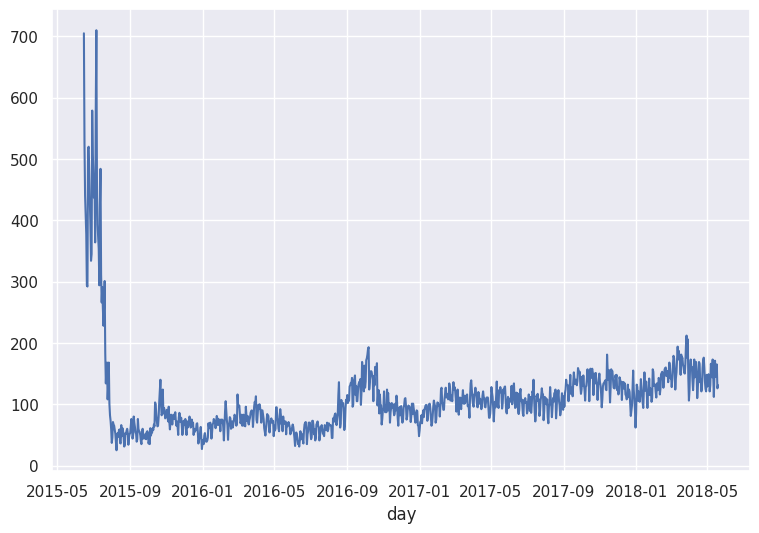

In [19]:
events_data.groupby('day') \
.user_id.nunique().plot()

In [20]:
#calculation "passed" events in events_data.
#Calculation is wrong: we did not take into account users who "passed" but quit soon after
events_data[events_data.action == 'passed'] \
.groupby('user_id', as_index=False) \
.agg({'step_id': 'count'}) \
.rename(columns = {'step_id' : 'passed_steps'}).head()

,user_id,passed_steps
0,2,9
1,3,87
2,5,11
3,7,1
4,8,84


<Axes: >

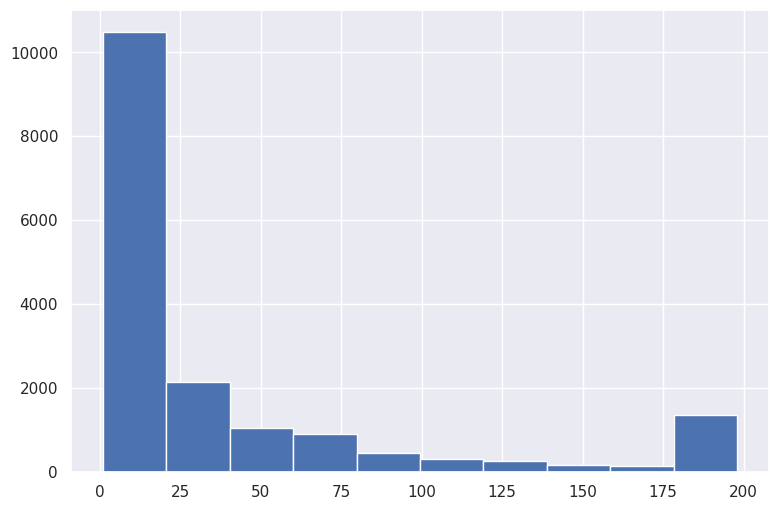

In [21]:
events_data[events_data.action == 'passed'] \
.groupby('user_id', as_index=False) \
.agg({'step_id': 'count'}) \
.rename(columns = {'step_id' : 'passed_steps'}).passed_steps.hist()

In [22]:
#Correct calculation
#To take into account all users / events when user 'passed' but did not continue
events_data.pivot_table(index='user_id',
                        columns='action',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index().head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


<Axes: >

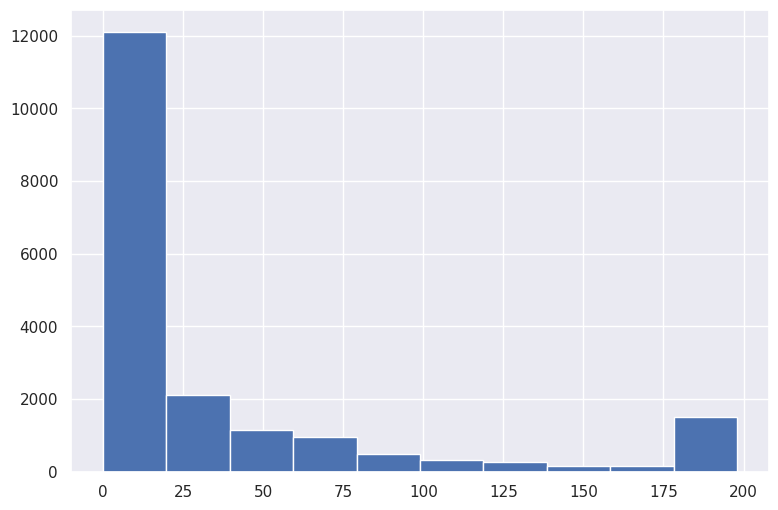

In [23]:
events_data.pivot_table(index='user_id',
                        columns='action',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index().discovered.hist()

In [ ]:
'''
The next question is the most important for the model prediction
We want to predict the percentage of students that will finish the online course
But how to distinguish between students who is already dropped amd who is stopped it on pause for 5 days?
To answer this question, let's do statistic analysis for each unique user and days between studies using db events_data
'''

In [24]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [ ]:
#events_data[['user_id', 'step_id']].head().drop_duplicates()

,user_id,step_id
0,17632,32815
3,17632,32811


In [25]:
#remove duplicates in columns 'user_id' and 'day'.
#Next groupby all timestamp for each user while being on the course and check the breaks between the timestamps
events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list).head()

user_id
1                                         [1472827464]
2                             [1514383364, 1519226966]
3    [1434358476, 1441257725, 1441440209, 144153391...
5                             [1466156809, 1499859621]
7                                         [1521634660]
Name: timestamp, dtype: object

In [26]:
# using np.diff to see how mmuch time passed between unique days / events while user been on the course
events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).head()

user_id
1                                                  []
2                                           [4843602]
3    [6899249, 182484, 93710, 2768870, 171400, 78712]
5                                          [33702812]
7                                                  []
Name: timestamp, dtype: object

In [27]:
#put data together with .values method (data will be in arrays)
events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values

array([array([], dtype=int64), array([4843602]),
       array([6899249,  182484,   93710, 2768870,  171400,   78712]), ...,
       array([   86128,   136759,    94899,  1422583, 14347289,   505061,
                 98252,    57019])                                       ,
       array([1567990]), array([], dtype=int64)], dtype=object)

In [28]:
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
    .groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values

In [29]:
# Now, the array with arrays we will transform in one array
np.concatenate(gap_data, axis=0)

array([4843602, 6899249,  182484, ...,   98252,   57019, 1567990])

In [30]:
#for convinience let's place it in pandas series
# now, for each user we have unique values of difference between two the nearest events when user went to the online platform
gap_data = pd.Series(np.concatenate(gap_data, axis=0))

In [31]:
#let's show this difference between two nearest events when user went to the online platform in days
gap_data = gap_data / (24 *60 * 60)

<Axes: >

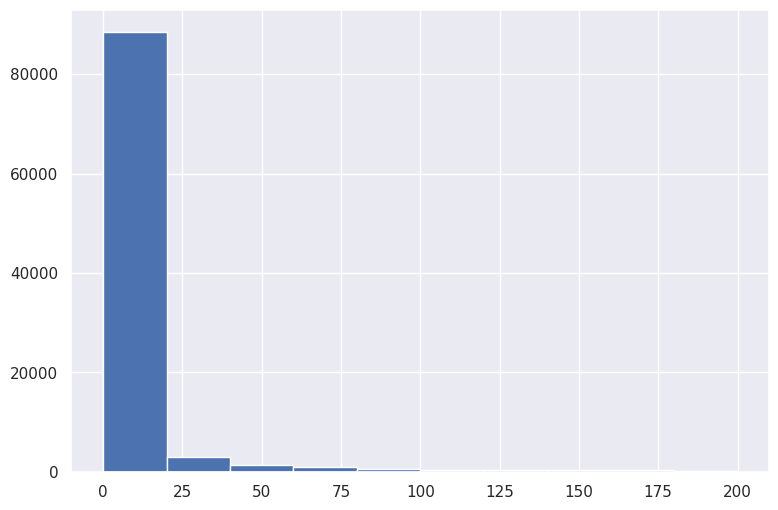

In [32]:
gap_data[gap_data < 200].hist()

In [33]:
#from these data, only 5% users come back to the course after about 2 months (59.76 days)
gap_data.quantile(0.95)

59.760440972222156

In [34]:
gap_data.quantile(0.90)

18.325995370370403

In [ ]:
#users_scores.sort_values('correct', ascending=False)

In [35]:
# Control value for calculation gap_data for each user (30 days in sec)
30 *24 *60 * 60

2592000

In [36]:
'''
From the data we can say that if user did not appear on the platform for more than 30 days
and did not obtain a certificate - the user dropped the online course
The calculation will be from the end of the data, i.e. 2018-05-19
'''
events_data.tail()

,step_id,timestamp,action,user_id,date,day
3480698,33375,1526772685,viewed,11677,2018-05-19 23:31:25,2018-05-19
3480699,32815,1526772750,viewed,5198,2018-05-19 23:32:30,2018-05-19
3480700,32815,1526772750,discovered,5198,2018-05-19 23:32:30,2018-05-19
3480701,32815,1526772750,passed,5198,2018-05-19 23:32:30,2018-05-19
3480702,33892,1526772811,viewed,18526,2018-05-19 23:33:31,2018-05-19


In [ ]:
#For each user, let's calculate the maximum timestamp, i.e. max of the user being on th ecourse

# users_data = events_data.groupby('user_id', as_index=False) \
#   .agg({'timestamp': 'max'}).head()

In [37]:
users_data = events_data.groupby('user_id', as_index=False) \
  .agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_timestamp'})

In [38]:
users_data.head()

,user_id,last_timestamp
0,1,1472827464
1,2,1519226966
2,3,1444581588
3,5,1499859939
4,7,1521634660


In [39]:
now = 1526772811
drop_out_threshold = 2592000

In [40]:
users_data['is_gone_user'] = (now - users_data.last_timestamp) > drop_out_threshold

In [41]:
#time spend since the last entry of the user in comporasion with the last time events
users_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


In [42]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [43]:
users_data = users_data.merge(users_scores, on='user_id', how='outer')

In [44]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,NaN,NaN
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,NaN,NaN


In [45]:
users_data = users_data.fillna(0)

In [46]:
users_data.head(20)

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0
5,8,1481466913,True,9.0,21.0
6,9,1484999497,True,0.0,0.0
7,11,1526140625,False,0.0,0.0
8,14,1436368676,True,0.0,1.0
9,16,1513162585,True,77.0,106.0


In [47]:
users_events_data = events_data.pivot_table(index='user_id',
                        columns='action',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index()

In [48]:
users_events_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [49]:
#lets merge users_events_data to users_data
users_data = users_data.merge(users_events_data, how='outer')

In [50]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed
0,1,1472827464,True,0.0,0.0,1,0,0,1
1,2,1519226966,True,2.0,0.0,9,9,2,10
2,3,1444581588,True,29.0,23.0,91,87,30,192
3,5,1499859939,True,2.0,2.0,11,11,4,12
4,7,1521634660,True,0.0,0.0,1,1,0,1


In [ ]:
# #transorm to Dataframe
# users_day.to_frame()

In [ ]:
# #reset index in DF
# users_day.to_frame().reset_index()

In [51]:
#Adding data how many days each user was on the platform
users_day = events_data.groupby('user_id').day.nunique().to_frame().reset_index()

In [52]:
users_day.head()

,user_id,day
0,1,1
1,2,2
2,3,7
3,5,2
4,7,1


In [53]:
# merge these users_day data to users_data
users_data = users_data.merge(users_day, how='outer')

In [54]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


In [55]:
#Check for correct number of users & events
users_data.user_id.nunique()

19234

In [56]:
events_data.user_id.nunique()

19234

In [57]:
'''
Add column if it is True that user successfully finish the course
Let's assume that if user passed more than 170 steps then he passed the course
according to our histogram
'''
users_data['passed_course'] = users_data.passed > 170

In [58]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False


In [59]:
users_data.groupby('passed_course').count()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_course,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425


In [60]:
# percentage of users who passed the course
100 * 1425 / 17809

8.001572238755685

In [ ]:
# users_data[users_data.passed_course].day.median()

20.0

<Axes: >

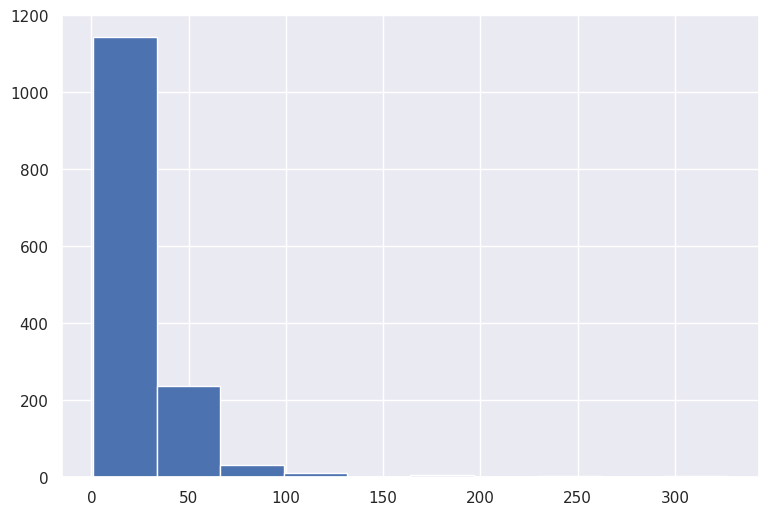

In [ ]:
# users_data[users_data.passed_course].day.hist()

In [61]:
#Task: extract the data for each user for the first three days from the moment
#when user was registered and made first activity event

user_min_time = events_data.groupby('user_id', as_index=False) \
  .agg({'timestamp' : 'min'})\
  .rename({'timestamp': 'min_timestamp'}, axis=1)

In [62]:
#Here for each user we have a min time
user_min_time.head()

,user_id,min_timestamp
0,1,1472827464
1,2,1514383364
2,3,1434358476
3,5,1466156809
4,7,1521634660


In [63]:
#Add this info to users_data dataFrame
users_data = users_data.merge(user_min_time, how='outer')
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


In [64]:
events_data['user_time'] = events_data.user_id.map(str) + '_' + events_data.timestamp.map(str)

In [66]:
learning_time_threshold = 3 *  24 *60 * 60 #3 - days and time in sec

In [67]:
user_learning_time_treshold = user_min_time.user_id.map(str) + '_' + (user_min_time.min_timestamp +
                                                                       learning_time_threshold).map(str)

In [ ]:
'''
for each user we need to collect events from the first detecte user' event
during the 3 days
'''
# #add 'user_time' column to events_data and concatenate two columns with user's timestamp
# events_data['user_time'] = events_data.user_id.map(str) + '_' + events_data.timestamp.map(str)

# events_data_train = events_data.merge(users_data[['user_id', 'min_timestamp']], on='user_id', how='left') \
#     .query("(timestamp - min_timestamp) < (3 * 24 * 60 * 60)")

# events_data_train = events_data[events_data.groupby('user_id')['timestamp'] \
#                     .apply(lambda x: x <= (x.min() + 3*24*60*60) )]

#last version
# events_data_train = events_data[
#     events_data['timestamp'] <= events_data
#     .merge(users_data[['user_id', 'min_timestamp']], how='left')
#     .min_timestamp + 3 * 24 * 60 * 60]

In [68]:
user_min_time['user_learning_time_treshold'] = user_learning_time_treshold
events_data = events_data.merge(user_min_time[['user_id', 'user_learning_time_treshold']], how = 'outer')
#events_data['user_time'] = events_data.user_id.map(str)+'_'+events_data.timestamp.map(str)


events_data_train = events_data[events_data.user_time <= events_data.user_learning_time_treshold]

In [ ]:
# user_events = events_data.merge(users_data[['user_id', 'min_timestamp']], on='user_id', how='outer')
# threshold = 3 * 24 * 60 * 60
# events_data_train = user_events.query('timestamp < min_timestamp + @threshold')

# submission_events = submissions_data.merge(users_data[['user_id', 'min_timestamp']], on='user_id', how ='outer')
# threshold = 3 * 24 * 60 * 60
# submissions_data_train = submission_events.query('timestamp < min_timestamp + @threshold')
# submissions_data_train = submission_events.query('timestamp < min_timestamp + @threshold')

In [ ]:
# learning_time_threshold = 3 *  24 *60 * 60
# events_data['user_time'] = events_data.user_id.map(str) + '_' + events_data.timestamp.map(str)

# user_learning_time_treshold = user_min_time.user_id.map(str) + '_' + (user_min_time.min_timestamp + learning_time_treshold).map(str)

# user_min_time['user_learning_time_treshold'] = user_learning_time_treshold
# events_data = events_data.merge(user_min_time[['user_id', 'user_learning_time_treshold']], how='outer')
# events_data_train = events_data[events_data.user_time <= events_data.user_learning_time_treshold]

In [69]:
events_data_train.head()

,step_id,timestamp,action,user_id,date,day,user_time,user_learning_time_treshold
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15,17632_1434340848,17632_1434600048
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15,17632_1434340895,17632_1434600048


In [70]:
events_data.shape

(3480703, 8)

In [71]:
events_data_train.shape

(1014985, 8)

In [72]:
#Check if threshould level for 3 days are working.
#Max value we got is 4 - which can be explained that user registere end of the
#1st day and after three 24-hours cycle, the 4th day will be also counted.
events_data_train.groupby('user_id').day.nunique().max()

4

In [73]:
submissions_data['users_time'] = submissions_data.user_id.map(str) + '_' + submissions_data.timestamp.map(str)
submissions_data = submissions_data.merge(user_min_time[['user_id', 'user_learning_time_treshold']], how='outer')
submissions_data_train = submissions_data[submissions_data.users_time <= submissions_data.user_learning_time_treshold]
submissions_data_train.groupby('user_id').day.nunique().max()

4

In [74]:
X = submissions_data_train.groupby('user_id').day.nunique().to_frame().reset_index().rename(columns={'day':'days'})

In [75]:
X.head()

,user_id,days
0,2,1
1,3,1
2,8,1
3,14,1
4,16,3


In [76]:
steps_tried = submissions_data_train.groupby('user_id').step_id.nunique().to_frame().reset_index() \
.rename(columns={'step_id':'steps_tried'})

In [77]:
steps_tried.head()

,user_id,steps_tried
0,2,2
1,3,4
2,8,11
3,14,1
4,16,23


In [78]:
X = X.merge(steps_tried, on='user_id' , how='outer')

In [79]:
X.shape

(8913, 3)

In [80]:
X = X.merge(submissions_data_train.pivot_table(index='user_id' ,
                        columns='submission_status' ,
                        values = 'step_id' ,
                        aggfunc = 'count' ,
                       fill_value=0).reset_index())


In [81]:
X['correct_ratio'] = X.correct / (X.correct + X.wrong)

In [82]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio
0,2,1,2,2,0,1.00
1,3,1,4,4,4,0.50
2,8,1,11,9,21,0.30
3,14,1,1,0,1,0.00
4,16,3,23,23,27,0.46


In [83]:
X = X.merge(events_data_train.pivot_table(index='user_id' ,
                        columns='action' ,
                        values = 'step_id' ,
                        aggfunc = 'count' ,
                       fill_value=0).reset_index()[['user_id','viewed']],how='outer')

In [84]:
X = X.fillna(0)

In [85]:
users_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day,passed_course,min_timestamp
0,1,1472827464,True,0.0,0.0,1,0,0,1,1,False,1472827464
1,2,1519226966,True,2.0,0.0,9,9,2,10,2,False,1514383364
2,3,1444581588,True,29.0,23.0,91,87,30,192,7,False,1434358476
3,5,1499859939,True,2.0,2.0,11,11,4,12,2,False,1466156809
4,7,1521634660,True,0.0,0.0,1,1,0,1,1,False,1521634660


In [86]:
X = X.merge(users_data[['user_id', 'passed_course','is_gone_user']] , how='outer')

In [87]:
#extract users that did not finish the course and did not quite it
X = X[-((X.is_gone_user == False) & (X.passed_course == False))]

In [88]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed,passed_course,is_gone_user
0,2,1.0,2.0,2.0,0.0,1.00,9,False,True
1,3,1.0,4.0,4.0,4.0,0.50,20,False,True
2,8,1.0,11.0,9.0,21.0,0.30,154,False,True
3,14,1.0,1.0,0.0,1.0,0.00,9,False,True
4,16,3.0,23.0,23.0,27.0,0.46,132,True,True


In [89]:
#check
X.groupby(['passed_course', 'is_gone_user']).user_id.count()

passed_course  is_gone_user
False          True            16560
True           False             141
               True             1284
Name: user_id, dtype: int64

In [90]:
y = X.passed_course.map(int)

In [91]:
X = X.drop(['passed_course' , 'is_gone_user'] , axis=1)

In [92]:
X.head()

,user_id,days,steps_tried,correct,wrong,correct_ratio,viewed
0,2,1.0,2.0,2.0,0.0,1.00,9
1,3,1.0,4.0,4.0,4.0,0.50,20
2,8,1.0,11.0,9.0,21.0,0.30,154
3,14,1.0,1.0,0.0,1.0,0.00,9
4,16,3.0,23.0,23.0,27.0,0.46,132


In [93]:
# set_index of user_id because we don't want use this column for model but don't want drop data either
X = X.set_index(X.user_id)
X = X.drop('user_id' , axis=1)

In [94]:
X.head()

,days,steps_tried,correct,wrong,correct_ratio,viewed
user_id,,,,,,
2,1.0,2.0,2.0,0.0,1.00,9
3,1.0,4.0,4.0,4.0,0.50,20
8,1.0,11.0,9.0,21.0,0.30,154
14,1.0,1.0,0.0,1.0,0.00,9
16,3.0,23.0,23.0,27.0,0.46,132


In [95]:
X.shape

(17985, 6)

In [96]:
y.shape

(17985,)

In [ ]:
#Save the preprocessed data
X.to_csv('/content/sample_data/X_data.csv')
y.to_csv('/content/sample_data/Y_data.csv')

In [97]:
# Decision Trees

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

#split train dataset for training model as 25/75
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.25, random_state=42)

In [98]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Model
model = DecisionTreeClassifier()

# Parameters
param_grid = {
    'max_depth': range(1, 15),
    'min_samples_split': range(2, 300, 5),
    'min_samples_leaf': range(2, 300, 10)

}

# Create object  GridSearchCV
grid_search = GridSearchCV(
    model,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy'
)

# Train model
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(1, 15),
                         'min_samples_leaf': range(2, 300, 10),
                         'min_samples_split': range(2, 300, 5)},
             scoring='accuracy')

In [99]:
print("best paramenters:", grid_search.best_params_)
print("Quality of the model:", grid_search.best_score_)

best paramenters: {'max_depth': 3, 'min_samples_leaf': 112, 'min_samples_split': 2}
Quality of the model: 0.9197066009428152


In [100]:
# Results of griding the parameters
results = grid_search.cv_results_

# Extract paramenters
params = results['params']

# Create a list of parameeters for each set
max_depths = grid_search.best_params_['max_depth']
min_samples_split = grid_search.best_params_['min_samples_split']
min_samples_leaf = grid_search.best_params_['min_samples_leaf']

# Learn the classifier using best parameters
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depths, \
                                min_samples_split=min_samples_split, \
                                min_samples_leaf=min_samples_leaf)

clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=112)

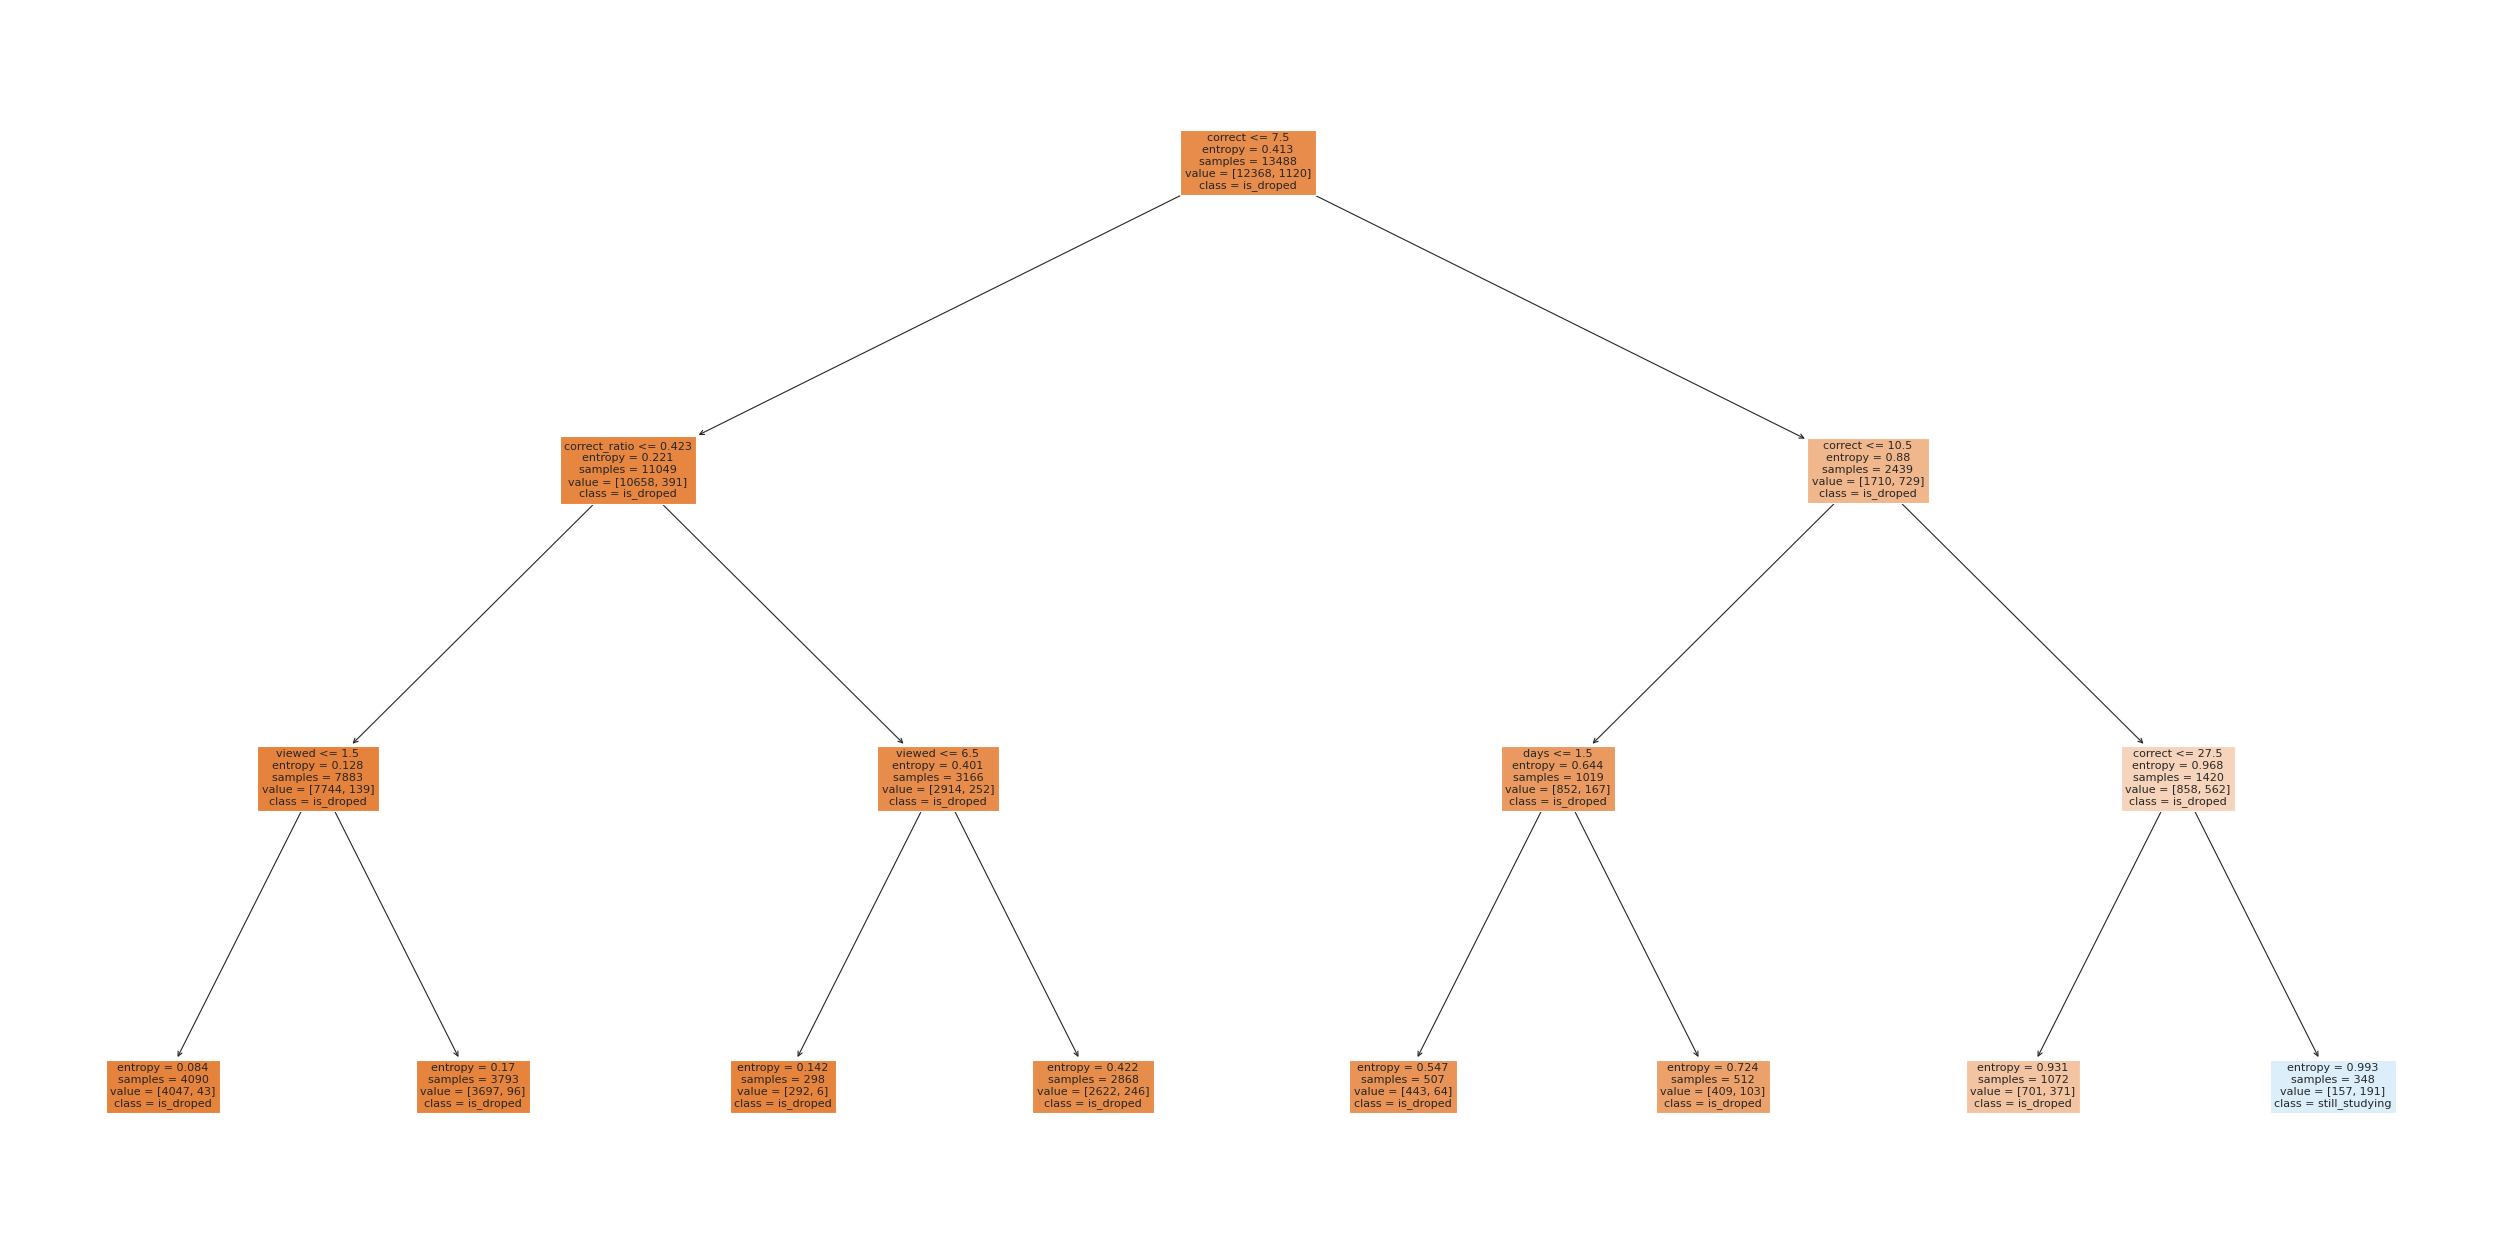

In [101]:
plt.figure(figsize=(40, 20),dpi=80)
p = tree.plot_tree(clf, fontsize=10,
                   filled=True,
                   feature_names=list(X),
                   class_names=['is_droped', 'still_studying'])

In [117]:
y_predicted = clf.predict(X_test)

pred_temp_df = pd.DataFrame({'predicted_status' : y_predicted})

pred_temp_df

,predicted_status
0,0
1,0
2,0
3,0
4,0
...,...
4492,0
4493,0
4494,0
4495,0


In [104]:
unique_values = np.unique(y_predicted)
print(unique_values)

[0 1]


In [124]:
test_df = X_test.copy()
test_df['true_status'] = y_test
test_df

In [123]:
#Here we drop the indices so that it can be combined with predicted values
result_df = test_df.reset_index()

# # Here in the cycle we will replace all values with entire numbers
# for name in ['days', 'steps_tried', 'correct', 'wrong']:
#     result_df[name] = result_df[name].map(int)

# # round the value
# result_df['correct_ratio'] = result_df['correct_ratio'].round(2)

# # Here we catch a column with predicted values
# result_df = result_df.join(pred_temp_df)

# # add a column that will show whether the prediction is True
# result_df['correct_prediction'] = result_df.true_status == result_df.predicted_status

# #result_df = result_df.set_index('user_id')

# result_df

In [122]:
result_df.groupby('correct_prediction').user_id.count()

correct_prediction
False    3783
True      714
Name: user_id, dtype: int64

In [125]:
clf.score(X_test, y_test)

0.9303980431398711

In [126]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score


print(f'- Accuracy of the model: {round(accuracy_score(y_test, y_predicted), 3)}')

#how many of the positive predictions made by the model
print(f'- Precision: {round(precision_score(y_test, y_predicted), 3)}')

#Recall: model's ability to correctly identify positive instances from the entire population of actual positives
print(f'- Recall: {round(recall_score(y_test, y_predicted), 3)}')

#The F1 score is the harmonic mean of precision and recall, providing a balanced measure of a model's performance.
print(f'- f1_score: {round(f1_score(y_test, y_predicted), 3)}')

- Accuracy of the model: 0.93
- Precision: 0.464
- Recall: 0.167
- f1_score: 0.246


In [ ]:
# from sklearn.metrics import precision_score, recall_score

# y_pred = np.where(y_predicted_prob[:, 1] > 0.5, 1, 0)
# print(precision_score(y_test, y_pred))
# print(recall_score(y_test, y_pred))

In [127]:
# Linear Regression
from sklearn.linear_model import LinearRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, roc_curve, auc

clf = LogisticRegressionCV(cv=5)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=41)

clf.fit(X_train, y_train)
print(clf.score(X_test,y_test))
print(clf.coef_)
print(clf.intercept_)
print(cross_val_score(clf,X_train,y_train,cv=4).mean())

0.926605504587156
[[ 6.09309107e-01 -3.89118803e-02  9.75724073e-02  5.52595311e-03
   9.75725077e-01 -9.51558362e-04]]
[-4.05637028]
0.9218098415346122


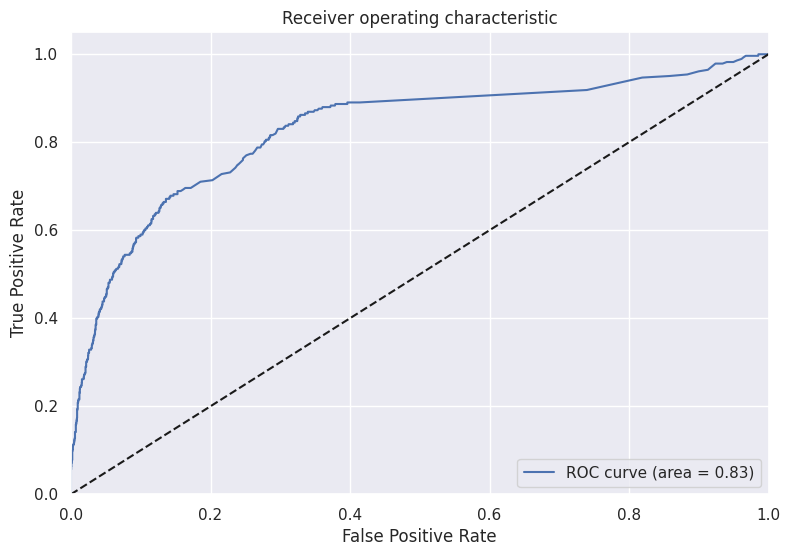

In [128]:
# Build ROC-curve
from sklearn.linear_model import LinearRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, roc_curve, auc

y_pred = clf.predict(X_test)
y_predicted_prob = clf.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_predicted_prob[:,1])
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
plt.plot([0, 1], [0, 1] , 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [129]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)
knn = KNeighborsClassifier()
parameters = {'n_neighbors': range(15,25), 'leaf_size':range(1,7)}
grid_search_cv_clf = GridSearchCV(knn,parameters,cv=4,n_jobs=-1)
grid_search_cv_clf.fit(X_train,y_train)
neibors_model = grid_search_cv_clf.best_estimator_
print(grid_search_cv_clf.best_params_, cross_val_score(model,X_train,y_train,cv=4).mean())

{'leaf_size': 1, 'n_neighbors': 19} 0.8993605782596609


In [130]:
y_predicted = neibors_model .predict(X_test)

print(f'- Accuracy of the model: {round(accuracy_score(y_test, y_predicted), 3)}')

#how many of the positive predictions made by the model
print(f'- Precision: {round(precision_score(y_test, y_predicted), 3)}')

#Recall: model's ability to correctly identify positive instances from the entire population of actual positives
print(f'- Recall: {round(recall_score(y_test, y_predicted), 3)}')

#The F1 score is the harmonic mean of precision and recall, providing a balanced measure of a model's performance.
print(f'- f1_score: {round(f1_score(y_test, y_predicted), 3)}')

- Accuracy of the model: 0.928
- Precision: 0.351
- Recall: 0.114
- f1_score: 0.173
